In [31]:
import scanpy as sc
import scvi

In [32]:
adata1 = sc.datasets.moignard15()

/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [33]:
adata1

AnnData object with n_obs × n_vars = 3934 × 42
    obs: 'exp_groups'
    uns: 'iroot', 'exp_groups_colors'

In [15]:
adata = sc.datasets.pbmc3k()

In [16]:
scvi.model.SCVI.setup_anndata(adata)

In [28]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: '_scvi_batch', '_scvi_labels', 'Z_0', 'Z_1', 'Z_2', 'Z_3', 'Z_4', 'Z_5', 'Z_6', 'Z_7', 'Z_8', 'Z_9', 'leiden_scVI'
    var: 'gene_ids'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_scVI_colors'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

In [17]:
n_latent = 10
model = scvi.model.SCVI(adata,n_hidden=n_latent,prior_distribution="normal")

New version.


In [18]:
model.train(max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s, v_num=1, train_loss_step=2.89e+3, train_loss_epoch=2.93e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:24<00:00,  4.09it/s, v_num=1, train_loss_step=2.89e+3, train_loss_epoch=2.93e+3]


In [19]:
Z = model.get_latent_representation()

In [21]:
for i, z in enumerate(Z.T):
    adata.obs[f"Z_{i}"] = z

In [24]:
adata.obsm["latent"] = Z

/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


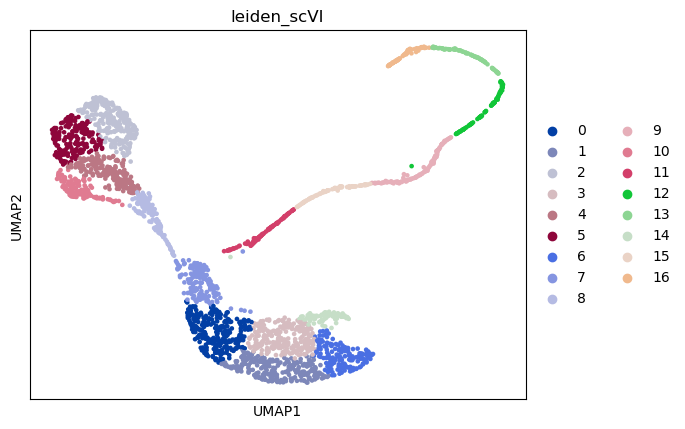

In [27]:
sc.pp.neighbors(adata,use_rep="latent",n_neighbors=50)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)
sc.pl.umap(adata, color=["leiden_scVI"])